# Web attack detection using CNN-BiLSTM neural network and CICIDS2017 dataset

In this notebook we implement web attack detection using CNN-BiLSTM neural network and CICIDS2017 dataset, and compare this neural network performance to our previously developed Random Forest model (https://github.com/BhargavP983/python-web-attack-detection/blob/main/web-attack-detection.ipynb).

Training data: https://github.com/BhargavP983/python-web-attack-detection/blob/main/datasets/zip%20datasets/web_attacks_balanced.zip

Training dataset is the balanced dataset based on CICIDS2017: https://www.unb.ca/cic/datasets/ids-2017.html
    
Sources:
- https://paperswithcode.com/paper/efficient-deep-cnn-bilstm-model-for-network
- Jay Sinha and M. Manollas. 2020. Efficient Deep CNN-BiLSTM Model for Network Intrusion Detection. In Proceedings of the 2020 3rd International Conference on Artificial Intelligence and Pattern Recognition (AIPR 2020). Association for Computing Machinery, New York, NY, USA, 223–231. DOI:https://doi.org/10.1145/3430199.3430224.
- https://github.com/razor08/Efficient-CNN-BiLSTM-for-Network-IDS/blob/master/NSL_KDD_Final.ipynb
    

## Data preprocessing

In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
from itertools import cycle
import pickle
import sys
import time
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Convolution1D, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential

%matplotlib inline

Load our dataset and separate it into feature vectors and labels. As explained in the previous work, 7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset (see https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/web-attack-detection.ipynb).

In [3]:
data = pd.read_csv('web_attacks_balanced.csv', delimiter=',')

y = data['Label']
X = data.drop(labels=['Label', 'Flow ID', 'Source IP', 'Source Port',
              'Destination IP', 'Destination Port', 'Protocol', 'Timestamp'], axis=1)

### Preparing feature vectors for training

First, we need to inspect feature vectors.

In [4]:
X

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,163.0,2.0,2.0,64.0,158.0,32.0,32.0,32.000000,0.000000,79.0,...,1.0,32.0,0.00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0
1,411.0,2.0,2.0,352.0,358.0,176.0,176.0,176.000000,0.000000,179.0,...,1.0,32.0,0.00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0
2,116446503.0,72.0,47.0,13380.0,15294.0,1313.0,0.0,185.833333,247.305081,3069.0,...,44.0,32.0,901129.75,1.767735e+06,3552487.0,296.0,28200000.0,1.590000e+07,49200000.0,11100000.0
3,196.0,2.0,2.0,88.0,188.0,44.0,44.0,44.000000,0.000000,94.0,...,1.0,32.0,0.00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0
4,178.0,2.0,2.0,48.0,48.0,24.0,24.0,24.000000,0.000000,24.0,...,1.0,32.0,0.00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,59.0,2.0,0.0,12.0,0.0,6.0,6.0,6.000000,0.000000,0.0,...,1.0,20.0,0.00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0
7263,24587.0,1.0,1.0,48.0,48.0,48.0,48.0,48.000000,0.000000,48.0,...,0.0,20.0,0.00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0
7264,80.0,2.0,0.0,12.0,0.0,6.0,6.0,6.000000,0.000000,0.0,...,1.0,20.0,0.00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0
7265,129.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,32.0,0.00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0


Check the absence of missing values in feature vectors.

In [5]:
X.isnull().values.any()

False

As we can see, the range of features is not normalized. We need to perform feature scaling for the correct functioning of selected deep learning algorithms (CNN and BiLSTM).

In our case, the min-max normalization is used: all selected features are transformed into the range [0, 1].

In [6]:
scaler = sklearn.preprocessing.MinMaxScaler()

To prevent data leakage, feature scaling would be performed on cross-validation folds at the training step.

### Preparing labels for training

First, we need to inspect labels.

In [7]:
y

0       BENIGN
1       BENIGN
2       BENIGN
3       BENIGN
4       BENIGN
         ...  
7262    BENIGN
7263    BENIGN
7264    BENIGN
7265    BENIGN
7266    BENIGN
Name: Label, Length: 7267, dtype: object

Check the absence of missing values in labels.

In [8]:
y.isnull().values.any()

False

As we can see, labels are categorical. We would need to transform them into the numeric form before the neural network training. In order to achieve that, we would apply one-hot encoding to labels.

To prevent data leakage, one-hot encoding would be performed within cross-validation folds at the training step.

## The neural network preparation

Define and compile the neural network.
<p> We use a sequential model with CNN and BiLSTM layers, and batch normalization is applied before BiLSTM layers. A dropout layer is put before the final layer to prevent overfitting.
<p> Categorical cross-entropy is chosen as a loss function because of the multiclass classification. To get the classification result, the softmax activation function is applied to the output of the last, fully connected layer. 

In [9]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=32, padding="same",
          activation="relu", input_shape=(76, 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape=(128, )))

model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))

model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [10]:
model.summary(line_length=100)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv1d (Conv1D)                             (None, 76, 64)                          2112           
                                                                                                    
 max_pooling1d (MaxPooling1D)                (None, 15, 64)                          0              
                                                                                                    
 batch_normalization (BatchNormalization)    (None, 15, 64)                          256            
                                                                                                    
 bidirectional (Bidirectional)               (None, 128)                             66048          
                                                                       

## The neural network training

We use Stratified K-Folds cross-validation in our experiment.

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Evaluation metrics are stored for each fold.

In [12]:
scores = pd.DataFrame(columns=[1, 2, 3, 4, 5, 'Mean'],
                      index=['Accuracy', 'Precision', 'Recall', 'F1'])

We use the following function to get evaluation metrics.

In [13]:
def print_metrics(y_eval: np.ndarray, y_pred: np.ndarray, average: str = 'binary') -> List[float]:
    accuracy = metrics.accuracy_score(y_eval, y_pred)
    precision = metrics.precision_score(y_eval, y_pred, average=average)
    recall = metrics.recall_score(y_eval, y_pred, average=average)
    f1 = metrics.f1_score(y_eval, y_pred, average=average)

    print('Accuracy =', accuracy)
    print('Precision =', precision)
    print('Recall =', recall)
    print('F1 =', f1)

    return [accuracy, precision, recall, f1]

All test and predicted labels are also stored at each step of cross-validation. They will be used to calculate a confusion matrix.

In [14]:
actual_targets = np.empty([0], dtype=float)
predicted_targets = np.empty([0], dtype=float)

On each fold, we use the following function to transform the data, to fit and to validate the neural network. Note that data preprocessing is largely performed at the cross-validation step to prevent data leakage.

In [15]:
def train_and_validate(model: Sequential,
                       X: pd.DataFrame,
                       y: pd.Series,
                       train_index: np.ndarray,
                       test_index: np.ndarray,
                       scaler: sklearn.preprocessing.MinMaxScaler) -> Tuple[np.ndarray, np.ndarray]:
    # Get the test data and the validation data for a current fold.
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Train index:", train_index)
    print("Test index:", test_index)

    # Feature scaling of data.
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # We need to reshape feature vectors to use them as the neural network input.
    X_train = np.reshape(
        X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(
        X_test, (X_test.shape[0], X_test.shape[1], 1))

    # One-Hot encoding for labels.
    y_train_encoded = pd.get_dummies(y_train).values
    y_test_encoded = pd.get_dummies(y_test).values

    # Fit the neural network model.
    model.fit(X_train, y_train_encoded, validation_data=(
        X_test, y_test_encoded), epochs=10)

    # Apply the neural network model to the validation data and get the accuracy of this prediction.
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_eval = np.argmax(y_test_encoded, axis=1)

    return y_eval, y_pred

The training step is designed for the use with different versions of Tensorflow, if necessary. It is also possible to choose whether the training should be performed by CPU or GPU.

This step may take some time, 13 minutes or more depending on the CPU performance (it will be faster with GPU).

In [16]:
# Tensorflow 1.14.

# This option may be used to speed up the CPU computation in some cases.
# import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_cpu_global_jit'

# Configure session parameters for the optimal parallelization and choose the computational device (CPU, GPU or both).
# config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=48,
#                                   inter_op_parallelism_threads=48, allow_soft_placement=True, device_count={'CPU': 24})
# with tf.compat.v1.Session(config=config) as sess:

# Tensorflow 2.X, the computation is performed on CPU.
with tf.device('/CPU:0'):

# Tensorflow 2.X, the computation is performed on GPU.
# with tf.device('/GPU:0'):

    # Set a timer for the learning time evaluation.
    start_time = time.time()
    
    i = 1
    # Stratified K-Folds cross-validation.
    for train_index, test_index in cv.split(X, y):
        y_eval, y_pred = train_and_validate(
            model, X, y, train_index, test_index, scaler)
        # Store test and predicted labels.
        actual_targets = np.append(actual_targets, y_eval)
        predicted_targets = np.append(predicted_targets, y_pred)
        # Get and print validation scores.
        print("Validation scores:")
        scores[i] = print_metrics(y_eval, y_pred, average='weighted')
        i += 1

    # Get the learning time.
    print('Total operation time: ', time.time() - start_time, 'seconds')

Train index: [   1    3    4 ... 7262 7264 7265]
Test index: [   0    2   17 ... 7258 7263 7266]


Epoch 1/10


182/182 [==============================] - 47s 77ms/step - loss: 0.3987 - accuracy: 0.8450 - val_loss: 0.9213 - val_accuracy: 0.6107
Epoch 2/10
182/182 [==============================] - 10s 57ms/step - loss: 0.2935 - accuracy: 0.8712 - val_loss: 0.9229 - val_accuracy: 0.7091
Epoch 3/10
182/182 [==============================] - 11s 60ms/step - loss: 0.2904 - accuracy: 0.8720 - val_loss: 0.3523 - val_accuracy: 0.8666
Epoch 4/10
182/182 [==============================] - 11s 61ms/step - loss: 0.2746 - accuracy: 0.8725 - val_loss: 0.3191 - val_accuracy: 0.8466
Epoch 5/10
182/182 [==============================] - 12s 65ms/step - loss: 0.2708 - accuracy: 0.8761 - val_loss: 0.3596 - val_accuracy: 0.8370
Epoch 6/10
182/182 [==============================] - 12s 64ms/step - loss: 0.2766 - accuracy: 0.8742 - val_loss: 0.3091 - val_accuracy: 0.8487
Epoch 7/10
182/182 [==============================] - 13s 71ms/step - loss: 0.2611 - accuracy: 0.8820 - val_loss: 0.2865 - val_accurac

f:\bharg\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 0.8466299862448419
Precision = 0.7892263714727666
Recall = 0.8466299862448419
F1 = 0.8131164063613195
Train index: [   0    2    3 ... 7264 7265 7266]
Test index: [   1   19   26 ... 7245 7252 7257]
Epoch 1/10
182/182 [==============================] - 10s 56ms/step - loss: 0.2615 - accuracy: 0.8798 - val_loss: 0.3518 - val_accuracy: 0.8418
Epoch 2/10
182/182 [==============================] - 11s 61ms/step - loss: 0.2568 - accuracy: 0.8799 - val_loss: 0.3644 - val_accuracy: 0.8384
Epoch 3/10
182/182 [==============================] - 10s 55ms/step - loss: 0.2552 - accuracy: 0.8810 - val_loss: 0.4258 - val_accuracy: 0.8398
Epoch 4/10
182/182 [==============================] - 24s 132ms/step - loss: 0.2470 - accuracy: 0.8835 - val_loss: 0.4108 - val_accuracy: 0.8521
Epoch 5/10
182/182 [==============================] - 14s 78ms/step - loss: 0.2450 - accuracy: 0.8837 - val_loss: 0.3478 - val_accuracy: 0.8487
Epoch 6/10
182/182 [==============================] - 12s 67ms/step -

f:\bharg\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


182/182 [==============================] - 10s 57ms/step - loss: 0.2630 - accuracy: 0.8796 - val_loss: 0.2994 - val_accuracy: 0.8617
Epoch 2/10
182/182 [==============================] - 11s 58ms/step - loss: 0.2556 - accuracy: 0.8798 - val_loss: 0.2754 - val_accuracy: 0.8830
Epoch 3/10
182/182 [==============================] - 13s 70ms/step - loss: 0.2529 - accuracy: 0.8801 - val_loss: 0.2900 - val_accuracy: 0.8685
Epoch 4/10
182/182 [==============================] - 12s 66ms/step - loss: 0.2474 - accuracy: 0.8836 - val_loss: 0.2864 - val_accuracy: 0.8789
Epoch 5/10
182/182 [==============================] - 11s 60ms/step - loss: 0.2431 - accuracy: 0.8865 - val_loss: 0.3071 - val_accuracy: 0.8624
Epoch 6/10
182/182 [==============================] - 10s 56ms/step - loss: 0.2468 - accuracy: 0.8842 - val_loss: 0.3273 - val_accuracy: 0.8644
Epoch 7/10
182/182 [==============================] - 11s 58ms/step - loss: 0.2463 - accuracy: 0.8853 - val_loss: 0.2657 - val_accuracy: 0.8624
Epo

f:\bharg\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


182/182 [==============================] - 11s 62ms/step - loss: 0.2626 - accuracy: 0.8799 - val_loss: 0.7441 - val_accuracy: 0.7164
Epoch 2/10
182/182 [==============================] - 10s 56ms/step - loss: 0.2491 - accuracy: 0.8858 - val_loss: 2.6009 - val_accuracy: 0.7013
Epoch 3/10
182/182 [==============================] - 10s 55ms/step - loss: 0.2447 - accuracy: 0.8842 - val_loss: 2.7735 - val_accuracy: 0.7109
Epoch 4/10
182/182 [==============================] - 11s 58ms/step - loss: 0.2556 - accuracy: 0.8806 - val_loss: 0.5095 - val_accuracy: 0.8837
Epoch 5/10
182/182 [==============================] - 10s 56ms/step - loss: 0.2458 - accuracy: 0.8860 - val_loss: 0.5822 - val_accuracy: 0.8782
Epoch 6/10
182/182 [==============================] - 10s 57ms/step - loss: 0.2501 - accuracy: 0.8853 - val_loss: 1.0101 - val_accuracy: 0.6992
Epoch 7/10
182/182 [==============================] - 11s 58ms/step - loss: 0.2411 - accuracy: 0.8846 - val_loss: 0.8624 - val_accuracy: 0.7068
Epo

f:\bharg\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


182/182 [==============================] - 10s 56ms/step - loss: 0.2469 - accuracy: 0.8863 - val_loss: 0.2356 - val_accuracy: 0.8906
Epoch 2/10
182/182 [==============================] - 10s 57ms/step - loss: 0.2403 - accuracy: 0.8884 - val_loss: 0.2331 - val_accuracy: 0.8947
Epoch 3/10
182/182 [==============================] - 10s 57ms/step - loss: 0.2342 - accuracy: 0.8942 - val_loss: 0.2786 - val_accuracy: 0.8741
Epoch 4/10
182/182 [==============================] - 10s 56ms/step - loss: 0.2341 - accuracy: 0.8928 - val_loss: 0.2278 - val_accuracy: 0.8954
Epoch 5/10
182/182 [==============================] - 10s 57ms/step - loss: 0.2386 - accuracy: 0.8910 - val_loss: 0.2384 - val_accuracy: 0.8926
Epoch 6/10
182/182 [==============================] - 12s 64ms/step - loss: 0.2433 - accuracy: 0.8880 - val_loss: 0.2329 - val_accuracy: 0.8954
Epoch 7/10
182/182 [==============================] - 11s 63ms/step - loss: 0.2394 - accuracy: 0.8889 - val_loss: 0.2327 - val_accuracy: 0.8885
Epo

f:\bharg\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model evaluation

Here we can see evaluation metrics for each fold and their mean values.

In [17]:
scores['Mean'] = scores.mean(axis=1)
scores

,1,2,3,4,5,Mean
Accuracy,0.846630,0.849381,0.849277,0.701996,0.892636,0.827984
Precision,0.789226,0.805646,0.909880,0.580387,0.856831,0.788394
Recall,0.846630,0.849381,0.849277,0.701996,0.892636,0.827984
F1,0.813116,0.819446,0.824854,0.581118,0.857364,0.77918


Visualize a confusion matrix for all folds of data to evaluate the classifier's performance. Here and further we use the following function.

In [18]:
def plot_confusion_matrix(y_eval: np.ndarray, y_pred: np.ndarray, labels: List[str]) -> None:
    # Get the confusion matrix for the last fold of data.
    confusion_matrix = metrics.confusion_matrix(y_eval, y_pred)

    # Evaluate accuracy and misclassification scores.
    accuracy = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))
    misclass = 1 - accuracy

    # Plot the confusion matrix.
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_eval, y_pred, display_labels=labels,
        xticks_rotation='vertical', cmap='Blues')
    plt.xlabel('Predicted label\n\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    plt.title('Confusion Matrix')
    plt.show()

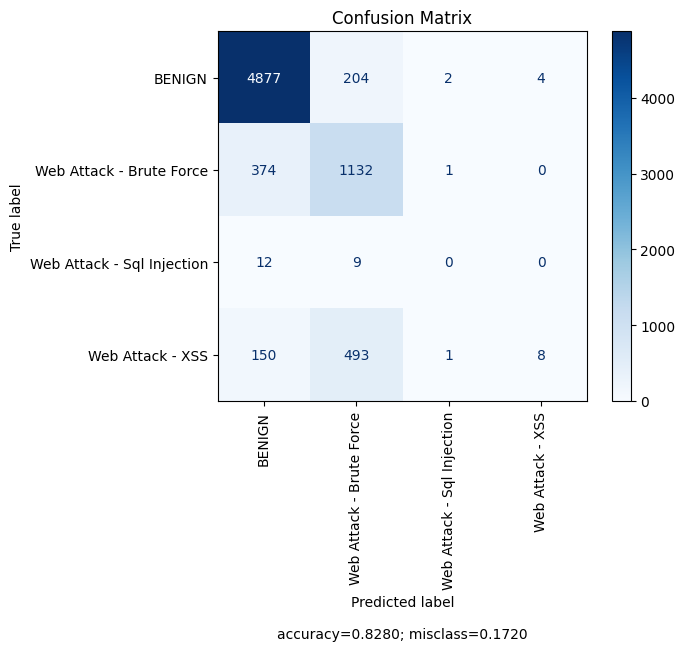

In [19]:
plot_confusion_matrix(actual_targets, predicted_targets, [
                      'BENIGN', 'Web Attack - Brute Force', 'Web Attack - Sql Injection', 'Web Attack - XSS'])

From the above confusion matrix, we can conclude that the model is mostly adequate in identifying benign traffic and brute force attacks.

## Comparison to Random Forest model

Download and open our previously developed model for this dataset: Random Forest (see https://github.com/BhargavP983/python-web-attack-detection/blob/main/web-attack-detection.ipynb).

In [20]:
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)
rfc

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

We use the indices of the final fold of Stratified K-Folds cross-validation to split the dataset into a training set with 80% of all the samples and test set with 20% of all the samples, preserving the percentage of samples for each class.

Our Random Forest model does not need feature scaling and uses only selected features, so we need to get correct feature vectors.

In [21]:
columns = ['Average Packet Size',
           'Flow Bytes/s',
           'Max Packet Length',
           'Fwd Packet Length Mean',
           'Fwd IAT Min',
           'Total Length of Fwd Packets',
           'Flow IAT Mean',
           'Fwd Packet Length Max',
           'Fwd IAT Std',
           'Fwd Header Length']
X_test = X.iloc[test_index]
X_test = X_test[columns]
X_test

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Flow IAT Mean,Fwd Packet Length Max,Fwd IAT Std,Fwd Header Length
5,50.666667,1.003516e+01,48.0,48.0,1999848.0,432.0,5.064547e+06,48.0,2.000000e+07,204.0
7,58.500000,9.708738e+05,66.0,34.0,3.0,68.0,6.866667e+01,34.0,0.000000e+00,64.0
8,51.000000,1.066484e+01,48.0,48.0,1989880.0,384.0,4.800822e+06,48.0,2.150000e+07,132.0
10,886.750000,5.106317e+06,1424.0,233.0,3.0,466.0,2.163333e+02,233.0,0.000000e+00,64.0
11,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,3.975457e+05,0.0,2.116411e+06,0.0
...,...,...,...,...,...,...,...,...,...,...
7248,9.000000,2.000000e+06,6.0,6.0,0.0,6.0,6.000000e+00,6.0,0.000000e+00,20.0
7249,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,9.300000e+01,0.0,0.000000e+00,32.0
7251,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,4.500000e+01,0.0,0.000000e+00,32.0
7253,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,7.083600e+04,0.0,0.000000e+00,32.0


Transform categorical labels into numeric form with simple label encoding. Note that our Random Forest model was developed for a binary classification task, so we transform labels accordingly: "0" indicates a benign instance and "1" an attack.

In [22]:
y_test = y[test_index]
y_test = y_test.apply(lambda x: 0 if x == 'BENIGN' else 1).values

Get the Random Forest model's evaluation metrics for the final fold of data.

f:\bharg\Python\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy = 0.9855471438403304
Precision = 0.9882352941176471
Recall = 0.963302752293578
F1 = 0.975609756097561


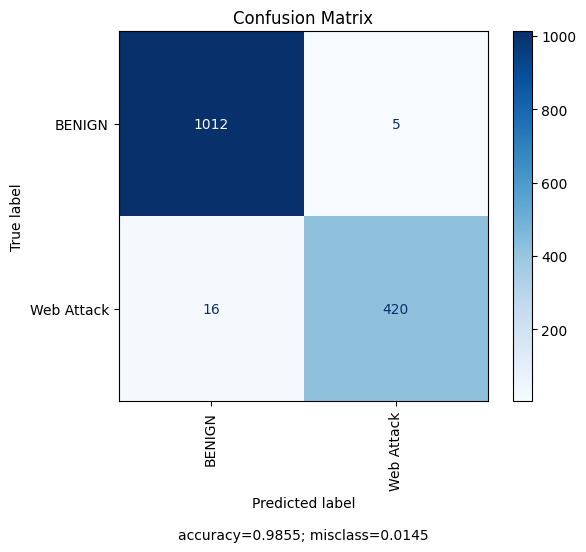

In [23]:
y_pred_rfc = rfc.predict(X_test.values)

metrics_rfc = print_metrics(y_test, y_pred_rfc)
plot_confusion_matrix(y_test, y_pred_rfc, ['BENIGN', 'Web Attack'])

The Random Forest model is designed for binary classification, whereas the CNN-BiLSTM model is designed for multiclass classification. To compare two models correctly, we change the output shape of the neural network model's dense layer so that the neural network predicts only two classes.

In [24]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=32, padding="same",
          activation="relu", input_shape=(76, 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape=(128, )))

model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))

model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [25]:
model.summary(line_length=100)

Model: "sequential_1"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv1d_1 (Conv1D)                           (None, 76, 64)                          2112           
                                                                                                    
 max_pooling1d_2 (MaxPooling1D)              (None, 15, 64)                          0              
                                                                                                    
 batch_normalization_2 (BatchNormalization)  (None, 15, 64)                          256            
                                                                                                    
 bidirectional_2 (Bidirectional)             (None, 128)                             66048          
                                                                     

Train the modified neural network on the final fold of data.

In [26]:
# Transform categorical labels into numeric form.
y = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1).values

y_eval, y_pred = train_and_validate(
    model, X, y, train_index, test_index, scaler)

Train index: [   0    1    2 ... 7264 7265 7266]
Test index: [   5    7    8 ... 7251 7253 7262]
Epoch 1/10


182/182 [==============================] - 29s 72ms/step - loss: 0.1533 - accuracy: 0.9362 - val_loss: 0.6549 - val_accuracy: 0.5664
Epoch 2/10
182/182 [==============================] - 10s 58ms/step - loss: 0.1030 - accuracy: 0.9577 - val_loss: 0.3686 - val_accuracy: 0.6999
Epoch 3/10
182/182 [==============================] - 10s 57ms/step - loss: 0.0872 - accuracy: 0.9659 - val_loss: 0.1587 - val_accuracy: 0.9415
Epoch 4/10
182/182 [==============================] - 10s 56ms/step - loss: 0.0815 - accuracy: 0.9647 - val_loss: 0.0938 - val_accuracy: 0.9642
Epoch 5/10
182/182 [==============================] - 10s 57ms/step - loss: 0.0903 - accuracy: 0.9632 - val_loss: 0.0985 - val_accuracy: 0.9491
Epoch 6/10
182/182 [==============================] - 12s 65ms/step - loss: 0.0821 - accuracy: 0.9665 - val_loss: 0.0967 - val_accuracy: 0.9518
Epoch 7/10
182/182 [==============================] - 12s 64ms/step - loss: 0.0830 - accuracy: 0.9659 - val_loss: 0.1571 - val_accuracy: 0.9270
Epo

Get the CNN-BiLSTM model's evaluation metrics for binary classification.

Accuracy = 0.961459050240881
Precision = 0.9611650485436893
Recall = 0.908256880733945
F1 = 0.9339622641509434


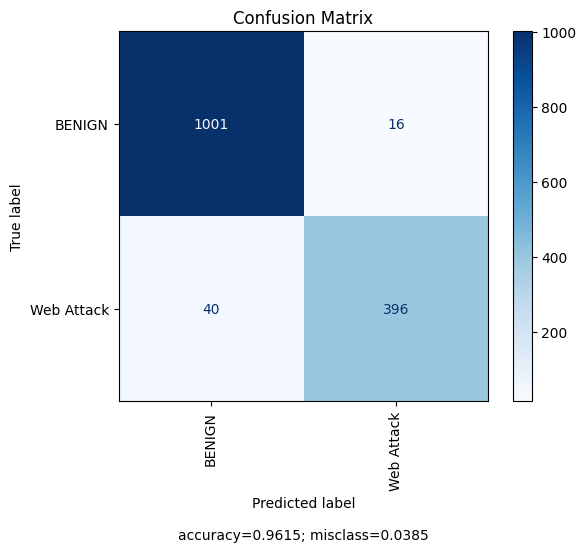

In [27]:
metrics_nn = print_metrics(y_eval, y_pred)
plot_confusion_matrix(y_eval, y_pred, ['BENIGN', 'Web Attack'])

Finally, compare evaluation metrics for Random Forest and CNN-BiLSTM models. Here we can see that the Random Forest model shows better results than the CNN-BiLSTM model, but the latter shows good results none the less. Further research is needed to achieve the desired performance.

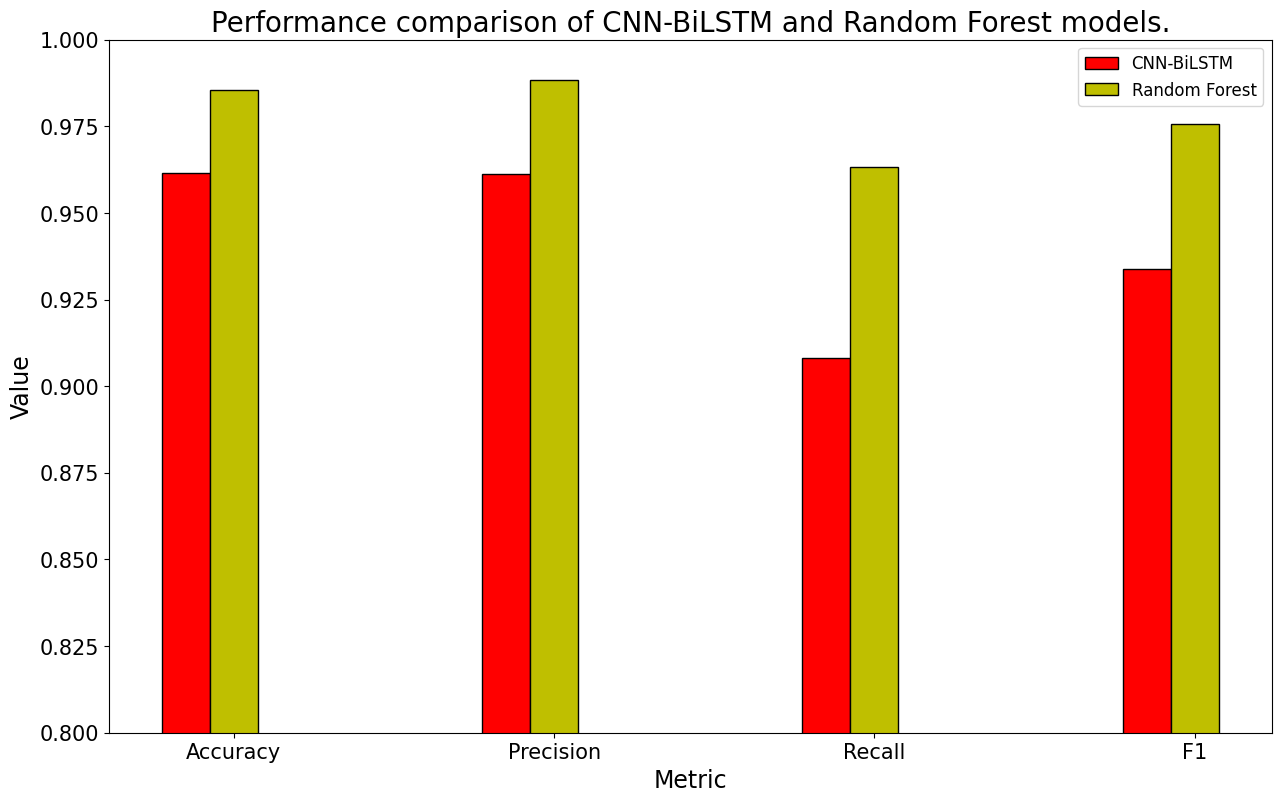

In [29]:
# Visualizing the data with a multiple bar chart.

# Scale the plot.
plt.figure(figsize=[15, 9])
plt.gca().set_ylim(0.8, 1)

# Get the data for the plot.
comparison_frame = pd.DataFrame(
    {'CNN-BiLSTM': metrics_nn, 'Random Forest': metrics_rfc},
    index=['Accuracy', 'Precision', 'Recall', 'F1'])

# Set the width of the bars.
wd = 0.3
x_pos = np.arange(1, 2*len(comparison_frame), 2)

# Plotting the multiple bar graphs on the same figure.
plt.bar(x_pos, comparison_frame['CNN-BiLSTM'], color='r', width=wd, edgecolor='k',
        label='CNN-BiLSTM')
plt.bar(x_pos+wd, comparison_frame['Random Forest'], color='y', width=wd, edgecolor='k',
        label='Random Forest')

# Add ticks, a title, and a legend.
plt.xticks(x_pos+wd, comparison_frame.index.values, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Metric', fontsize=17)
plt.ylabel('Value', fontsize=17)
plt.title(
    "Performance comparison of CNN-BiLSTM and Random Forest models.", fontsize=20)
plt.legend(loc='best', fontsize=12)

plt.show()